## Dynamic Flux Based Analysis

And write write write

In [2]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra import Model, Reaction, Metabolite

In [3]:
model = read_sbml_model('models/iMM904_progesterone_fixed.xml')

In [4]:
m = Metabolite("progesterone_e",formula="C21H30O2",name="EXprogesterone",compartment="e")

r = Reaction("T_progesterone")
model.add_reactions([r])
r.name = "T_progesterone"
r.lower_bound = 0.6
r.upper_bound = 1000
r.add_metabolites({"progesterone_c":-1,
                    m:1})
print(f'Adding reaction {r}')

model.add_boundary(model.metabolites.get_by_id('progesterone_e'), type='exchange')

Adding reaction T_progesterone: progesterone_c --> progesterone_e


Reaction identifier,EX_progesterone_e
Name,EXprogesterone exchange
Memory address,0x07fa9e55c2390
Stoichiometry,progesterone_e <=> EXprogesterone <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [5]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [6]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Pro = KineticVariable("Progesterone")
Oxy = KineticVariable("Oxygen")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Pro, Oxy])

In [7]:
# instances of ExchangeFlux

mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("EX_progesterone_e")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [8]:
# add rhs expressions for kinetic variables in dfba_model
#ENHEDER?
Vgmax = 8.5
Kg = 0.5
Gin = 100.0
Vomax = 8.0

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X ) #+ D * (Gin - Gluc) / V
#dfba_model.add_rhs_expression("Ethanol", v_E * X - D * Eth / V)
dfba_model.add_rhs_expression("Progesterone", v_P * X) # - D * Pro / V

In [9]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

In [37]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)
#IS THIS TRUE???

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.1,
        "Glucose": 10.0,
        "Oxygen": 2.0, 
        "Progesterone": 0.0
    }
)

In [38]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "EX_o2_e", "EX_progesterone_e"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 26
Number of residual evaluations     = 84
Number of Jacobian evaluations     = 17
Number of nonlinear iterations     = 40
Number of error test failures      = 3
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 119


Final Run Statistics: 

Number of steps                    = 2
Number of residual evaluations     = 6
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 3
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 12


Final Run Statistics: 

Number of steps                    = 12
Number of residual evaluations     = 30
Number of Jacobian evaluations     = 10
Number of nonlinear iterations     = 15
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 22


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluat

Text(0.5, 1.0, 'Batch fermentation')

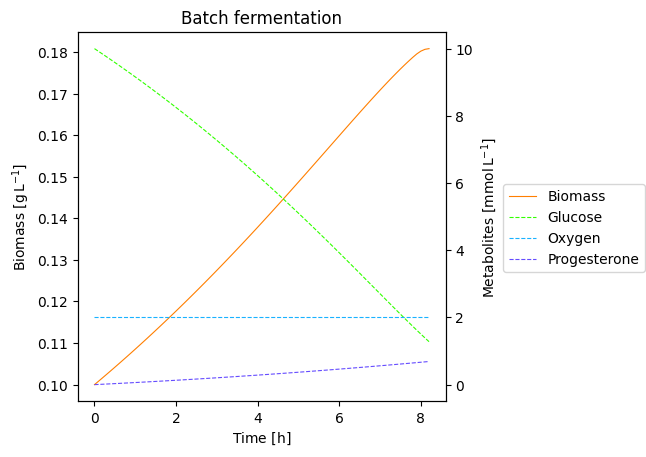

In [39]:
plot_concentrations(concentrations)
plt.title("Batch fermentation")

In [32]:
concentrations

,time,Biomass,Glucose,Oxygen,Progesterone
0,0.0,0.050000,10.000000,2.0,0.000000
1,0.1,0.050413,9.959361,2.0,0.003012
2,0.2,0.050830,9.918393,2.0,0.006050
3,0.3,0.051249,9.877093,2.0,0.009112
4,0.4,0.051672,9.835462,2.0,0.012200
...,...,...,...,...,...
127,12.7,0.129433,1.629415,2.0,0.655569
128,12.8,0.129950,1.545591,2.0,0.663350
129,12.9,0.130351,1.462593,2.0,0.671158
130,13.0,0.130621,1.380601,2.0,0.678985


In [31]:
Pro_mol = concentrations['Progesterone']/1000  #converting mmol/L to mol/L
Pro_Molar_mass = 314.46   #the calculated molar mass (g/mol) for progesterone
Pro_g_L = Pro_mol*Pro_Molar_mass   #calculate the concentration in g/L (g/L = g/mol * mol/L)
Pro_g_L

0      0.000000
1      0.000947
2      0.001902
3      0.002865
4      0.003836
         ...   
127    0.206150
128    0.208597
129    0.211052
130    0.213514
131    0.215979
Name: Progesterone, Length: 132, dtype: float64

In [34]:
concentrations2 = concentrations
concentrations2['Progesterone'] = Pro_g_L
concentrations2

,time,Biomass,Glucose,Oxygen,Progesterone
0,0.0,0.050000,10.000000,2.0,0.000000
1,0.1,0.050413,9.959361,2.0,0.000947
2,0.2,0.050830,9.918393,2.0,0.001902
3,0.3,0.051249,9.877093,2.0,0.002865
4,0.4,0.051672,9.835462,2.0,0.003836
...,...,...,...,...,...
127,12.7,0.129433,1.629415,2.0,0.206150
128,12.8,0.129950,1.545591,2.0,0.208597
129,12.9,0.130351,1.462593,2.0,0.211052
130,13.0,0.130621,1.380601,2.0,0.213514


<AxesSubplot:xlabel='time'>

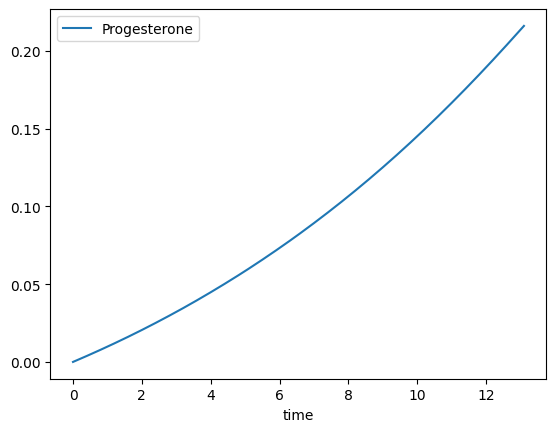

In [35]:
concentrations2.plot(x='time', y='Progesterone')

In [92]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 100.0,
        "Oxygen": 100.0, 
        "Progesterone": 0.0
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "EX_o2_e", "EX_progesterone_e"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 39
Number of residual evaluations     = 164
Number of Jacobian evaluations     = 25
Number of nonlinear iterations     = 80
Number of error test failures      = 12
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 377


Final Run Statistics: 

Number of steps                    = 10
Number of residual evaluations     = 26
Number of Jacobian evaluations     = 8
Number of nonlinear iterations     = 13
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 22


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 4
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 2
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 11


Final Run Statistics: 

Number of steps                    = 15
Number of residual evalu

Text(0.5, 1.0, 'Batch fermentation')

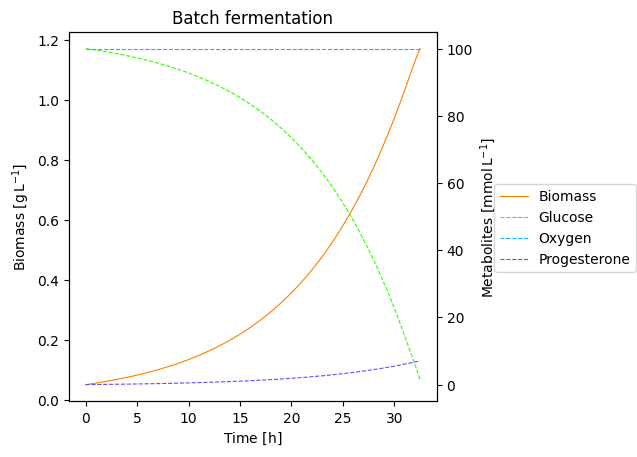

In [93]:
plot_concentrations(concentrations)
plt.title("Batch fermentation")

In [94]:
concentrations

,time,Biomass,Glucose,Oxygen,Progesterone
0,0.0,0.050000,100.000000,100.0,0.000000
1,0.1,0.050492,99.957504,100.0,0.003015
2,0.2,0.050989,99.914589,100.0,0.006059
3,0.3,0.051490,99.871248,100.0,0.009134
4,0.4,0.051997,99.827482,100.0,0.012239
...,...,...,...,...,...
321,32.1,1.139793,4.884597,100.0,6.821739
322,32.2,1.148917,4.010648,100.0,6.890402
323,32.3,1.157643,3.151076,100.0,6.959601
324,32.4,1.165724,2.317285,100.0,7.029306
